In [257]:
from evoVAE.utils.datasets import MSA_Dataset
import evoVAE.utils.seq_tools as st
import evoVAE.utils.metrics as mt
from evoVAE.models.seqVAE import SeqVAE
import pandas as pd
import torch
import numpy as np
import yaml
#pd.set_option("display.max_rows", None)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [319]:
path = "/Users/sebs_mac/uni_OneDrive/honours/data/mafg_mouse/alns/"

df = st.read_aln_file(path + "mafg_mouse.fasta")
df

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/mafg_mouse/alns/mafg_mouse.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 6165


id                                   sequence
0                  MAFG_MOUSE/1-41  LTDEELVTMSVRELNQHLRGLSKEEIIQLKQRRRTLKNRGY
1       UniRef100_A0A3M6U3Z1/45-84  -DDEYLERTSIQELNKKLRRLPEGLIRKFRKRRRILKNRKY
2     UniRef100_A0A3M6U3Z1/223-262  -TDLEIATLPIRELNKRMKNLPQAEVLQIRKRRRSLRNRDY
3     UniRef100_A0A3M6U3Z1/418-457  -SDEQIQNLRVQDLNKLLRDLPRDEAAKIKKRRRNLKNRNY
4      UniRef100_A0A2B4S600/80-119  -TDDELISISIRLLNQRLKNLPKTAAKQIRKRRRSLKNRGY
...                            ...                                        ...
6160     UniRef100_A0A4Z2CUU6/5-47  LTDDELLDMTTVDLRLLLKRLTVEEHKELRNRRRRLQNRRY
6161     UniRef100_A0A4Z2CVB4/5-47  LTDDELLDMTTVDLRLLLKRLTVEEHKELRNRRRRLQNRRY
6162         UniRef100_C1LHG2/5-47  LTDDELLDMTTVDLRLLLKRLTVEEHKELRNRRRRLQNRRY
6163         UniRef100_B3GUW6/5-47  LTDDELLDMTTVDLRLLLKRLTVEEHKELRNRRRRLQNRRY
6164         UniRef100_Q86EN5/5-47  LTDDELLDMTTVDLRLLLKRLTVEEHKELRNRRRRLQNRRY

[6165 rows x 2 columns]

In [320]:
df.drop_duplicates(subset=["sequence"], inplace=True)
df

id                                   sequence
0                  MAFG_MOUSE/1-41  LTDEELVTMSVRELNQHLRGLSKEEIIQLKQRRRTLKNRGY
1       UniRef100_A0A3M6U3Z1/45-84  -DDEYLERTSIQELNKKLRRLPEGLIRKFRKRRRILKNRKY
2     UniRef100_A0A3M6U3Z1/223-262  -TDLEIATLPIRELNKRMKNLPQAEVLQIRKRRRSLRNRDY
3     UniRef100_A0A3M6U3Z1/418-457  -SDEQIQNLRVQDLNKLLRDLPRDEAAKIKKRRRNLKNRNY
4      UniRef100_A0A2B4S600/80-119  -TDDELISISIRLLNQRLKNLPKTAAKQIRKRRRSLKNRGY
...                            ...                                        ...
6150     UniRef100_A0A5K3EET0/7-48  -SDEELVQMTTIQLRNLLQVISQEQHRELRTRRRRLQNRKY
6151     UniRef100_A0A183LAV5/5-47  LTDDELVDMTTADLRLLLKRVTIEEHKELRSRRRRLQNRKY
6156     UniRef100_A0A0R3TLP5/7-48  -TDEELVQMTTVQLRNLLNIITPDQHQELRVRRRRLQNRKY
6159     UniRef100_A0A564YPJ8/8-49  -TDEELVQMTTGQLRNLLNIITLDQHQELRMRRRRLQNRKY
6160     UniRef100_A0A4Z2CUU6/5-47  LTDDELLDMTTVDLRLLLKRLTVEEHKELRNRRRRLQNRRY

[962 rows x 2 columns]

In [321]:
st.write_fasta_file(path + "mafg_extants_no_dupes.fasta", df)

# Model init

In [341]:
with open("../data/dummy_config.yaml", "r") as stream:
    settings = yaml.safe_load(stream)


In [611]:
def plot_latent_2D(data, wt_id, label, ax, data_label, rgb=False):


    pca = PCA(n_components=2)

    zs_2d = pca.fit_transform(np.vstack(data["z"].values))

    data["pca"] = list(zs_2d)

    # Filter ancestors and extants
    ancestors = data[data['id'].str.contains("tree")]
    extants = data[~data['id'].str.contains("tree")]
    wt = data[data['id'] == wt_id]
    variants = data[data['id'].str.contains(":")]
    
    an_rgb = "red"
    ex_rgb = "blue"
    var_rgb = "orange"
    if rgb:
        an_rgb = np.array([rgb_to_hex_normalized(*((z - np.min(z)) / (np.max(z) - np.min(z)))) for z in ancestors["z"]])
        ex_rgb = np.array([rgb_to_hex_normalized(*((z - np.min(z)) / (np.max(z) - np.min(z)))) for z in extants["z"]])
        var_rgb = np.array([rgb_to_hex_normalized(*((z - np.min(z)) / (np.max(z) - np.min(z))) ) for z in variants["z"]])

    ax.scatter(np.vstack(ancestors["pca"].values)[:, 0], np.vstack(ancestors["pca"].values)[:, 1], c=an_rgb, label='Ancestors', s=50, marker='>', alpha=0.5)
    #Plot extants
    ax.scatter(np.vstack(extants["pca"].values)[:, 0], np.vstack(extants["pca"].values)[:, 1], c=ex_rgb, label='Extants', s=50, marker='o', alpha=0.5)
    ax.scatter(np.vstack(variants["pca"].values)[:, 0], np.vstack(variants["pca"].values)[:, 1], c=var_rgb, label='Variants', s=50, marker='x', alpha=0.5)

    ax.scatter(np.vstack(wt["pca"].values)[:, 0], np.vstack(wt["pca"].values)[:, 1], c="black", label='WT', s=200, marker='*', alpha=1)
    
    ax.set_xlabel(f'PC1: {np.round(pca.explained_variance_ratio_[0] * 100, 2)}%')
    ax.set_ylabel(f'PC2 {np.round(pca.explained_variance_ratio_[1] * 100, 2)}%')
    
    ax.set_title(f"{data_label}: {label}")
    ax.legend()

def get_mean_z(model, data_loader, device, num_samples: int = 10) -> pd.DataFrame:

    names = []
    z_vals = []

    # SAMPLE Z VALUES FROM THE MODEL FOR EACH EXTANT
    for x, _, name in data_loader:
        #print(encoding.shape)

        x = x.expand(num_samples, -1, -1)
        x = torch.flatten(x, start_dim=1)
        x = x.to(torch.float32)
        x = x.to(device)

        mu, sigma = model.encoder(x)
        eps = torch.randn_like(sigma)
        z = mu + sigma * eps

        z = torch.mean(z, dim=0).detach().cpu().numpy()
        names.append(name[0])
        z_vals.append(z)

    id_to_z = pd.DataFrame({"id": names, "z": z_vals})

    return id_to_z


def plot_latent_3D(data, wt_id, label, ax, data_label, rgb=False):

    # Filter ancestors and extants
    ancestors = data[data['id'].str.contains("tree")]
    extants = data[~data['id'].str.contains("tree")]
    wt = data[data['id'] == wt_id]
    variants = data[data['id'].str.contains(":")]

    ax.set_xlabel('Z1')
    ax.set_ylabel('Z2')
    ax.set_zlabel('Z3')

    an_zs = np.array([z.tolist() for z in ancestors['z']])
    ex_zs = np.array([z.tolist() for z in extants['z']])
    variant_zs = np.array([z.tolist() for z in variants['z']])
    wt_zs = np.array([z.tolist() for z in wt['z']])

    # # Plot ancestors
    an_rgb = "red"
    ex_rgb = "blue"
    var_rgb = "orange"
    if rgb:
        an_rgb = np.array([rgb_to_hex_normalized(*((z - np.min(z)) / (np.max(z) - np.min(z))))  for z in an_zs])
        ex_rgb = np.array([rgb_to_hex_normalized(*((z - np.min(z)) / (np.max(z) - np.min(z)))) for z in ex_zs])
        var_rgb = np.array([rgb_to_hex_normalized(*((z - np.min(z)) / (np.max(z) - np.min(z)))) for z in variant_zs])

    ax.scatter(an_zs[:, 0], an_zs[:, 1], an_zs[:, 2], c=an_rgb, label='Ancestors', s=50, marker='>', alpha=0.2)
    #  Plot extants
    ax.scatter(ex_zs[:, 0], ex_zs[:, 1], ex_zs[:, 2], c=ex_rgb, label='Extants', s=50, marker='o', alpha=0.5)
    ax.scatter(variant_zs[:, 0], variant_zs[:, 1], variant_zs[:, 2], c=var_rgb, label='Variants', s=50, marker='x', alpha=1)
    ax.scatter(wt_zs[:, 0], wt_zs[:, 1], wt_zs[:, 2], c="black", label='WT', s=500, marker='*', alpha=1)

    #ax.view_init(elev=30, azim=40)  # Change these values to get the desired orientation
    ax.set_title(f"{data_label}: {label}")
    ax.legend()
    

def rgb_to_hex_normalized(r, g, b):
    # Scale the values from 0-1 to 0-255
    r_scaled = int(r * 255)
    g_scaled = int(g * 255)
    b_scaled = int(b * 255)
    
    # Convert to hexadecimal and combine
    return "#{0:02X}{1:02X}{2:02X}".format(r_scaled, g_scaled, b_scaled)


def rgb_to_hex(rgb):
    """Return color as #rrggbb for the given color values."""
    rounded_rgb = tuple(int(round(x)) for x in rgb)
    return '#%02X%02X%02X' % rounded_rgb


# GFP 

In [562]:
path = "/Users/sebs_mac/uni_OneDrive/honours/data/gfp/independent_runs/no_synthetic/alns/"
gfp_ae = pd.read_pickle(path + "gfp_ancestors_extants_no_syn_no_dupes.pkl")


variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/GFP_AEQVI_Sarkisyan_2016.csv")
variants.drop(columns=["DMS_score", "DMS_score_bin"], inplace=True)
variants.rename(columns={"mutant": "id", "mutated_sequence": "sequence"}, inplace=True)

all_gfps = pd.concat([gfp_ae, variants], ignore_index=True)

one_hot = all_gfps["sequence"].apply(st.seq_to_one_hot)
all_gfps["encoding"] = one_hot

gfp_ae_dataset = MSA_Dataset(all_gfps["encoding"], all_gfps["weights"], all_gfps["id"])
gfp_ae_loader = torch.utils.data.DataLoader(
    gfp_ae_dataset, batch_size=1, shuffle=False
)

seq_len = gfp_ae_dataset[0][0].shape[0]
input_dims = seq_len * settings["AA_count"]

device = torch.device("mps")
model = SeqVAE(
    dim_latent_vars=settings["latent_dims"],
    dim_msa_vars=input_dims,
    num_hidden_units=settings["hidden_dims"],
    settings=settings,
    num_aa_type=settings["AA_count"],
)

### GFP-AE model 

In [563]:
model = model.to(device)

model.load_state_dict(torch.load("/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/gfp_standard/gfp_ae/gfp_ae_r9/gfp_ae_r9_model_state.pt",
                                  map_location=device))

gfp_ae_latent = get_mean_z(model, gfp_ae_loader, device, 10)
gfp_ae_latent.head()

id                                     z
0                  GFP_AEQVI/1-238    [0.833069, -0.16138454, 3.0437887]
1    UniRef100_UPI0011C34247/2-231   [0.6078381, -0.15118794, 3.0510926]
2  UniRef100_UPI0011C34247/384-556  [-0.25742552, -1.8219963, 2.2246974]
3  UniRef100_UPI0011C3426C/384-556   [-0.33239534, -1.8279632, 2.348674]
4    UniRef100_UPI001C2E920B/3-240   [0.7917067, -0.29171038, 2.9986827]

### GFP-A model 

In [564]:
model.load_state_dict(torch.load("/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/gfp_standard/gfp_a/gfp_a_r4/gfp_a_r4_model_state.pt", map_location=device))
gfp_a_latent = get_mean_z(model, gfp_ae_loader, device, 10)
gfp_a_latent.head()

id                                      z
0                  GFP_AEQVI/1-238    [0.5228408, -0.3596689, -3.3076699]
1    UniRef100_UPI0011C34247/2-231    [0.8668413, -0.46979094, -2.955109]
2  UniRef100_UPI0011C34247/384-556  [-0.30495673, 0.02527137, -2.3711183]
3  UniRef100_UPI0011C3426C/384-556   [-0.53983897, 0.57485116, -2.366182]
4    UniRef100_UPI001C2E920B/3-240   [0.46579418, -0.4033436, -3.1856287]

### GFP-E model

In [565]:
model.load_state_dict(torch.load("/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/gfp_standard/gfp_e/gfp_e_r10/gfp_e_r10_model_state.pt", map_location=device))
gfp_e_latent = get_mean_z(model, gfp_ae_loader, device, 10)
gfp_e_latent.head()

id                                    z
0                  GFP_AEQVI/1-238     [1.54793, -0.7669139, 2.8210115]
1    UniRef100_UPI0011C34247/2-231  [1.4522631, -0.51942647, 2.5098302]
2  UniRef100_UPI0011C34247/384-556  [0.8592629, -0.47536024, 2.2420232]
3  UniRef100_UPI0011C3426C/384-556  [0.9093176, -0.045973755, 2.169434]
4    UniRef100_UPI001C2E920B/3-240  [1.5302967, -0.52196854, 2.7382348]

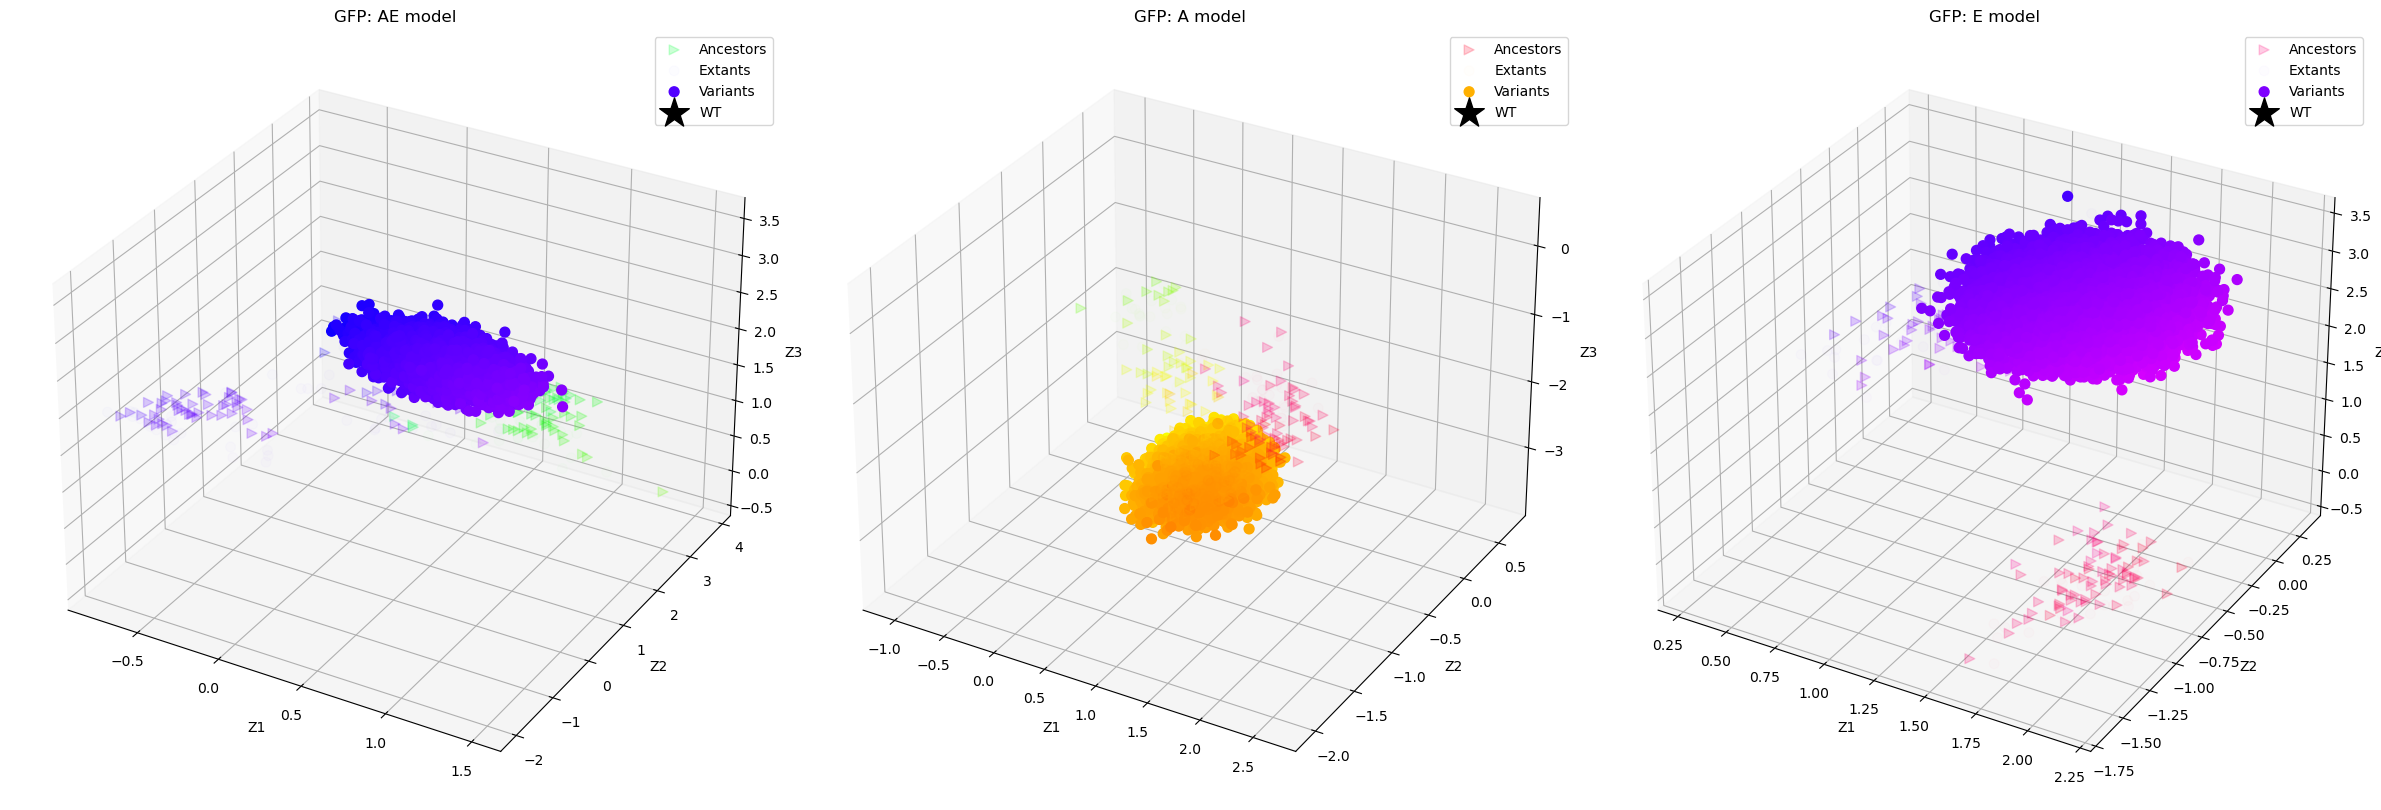

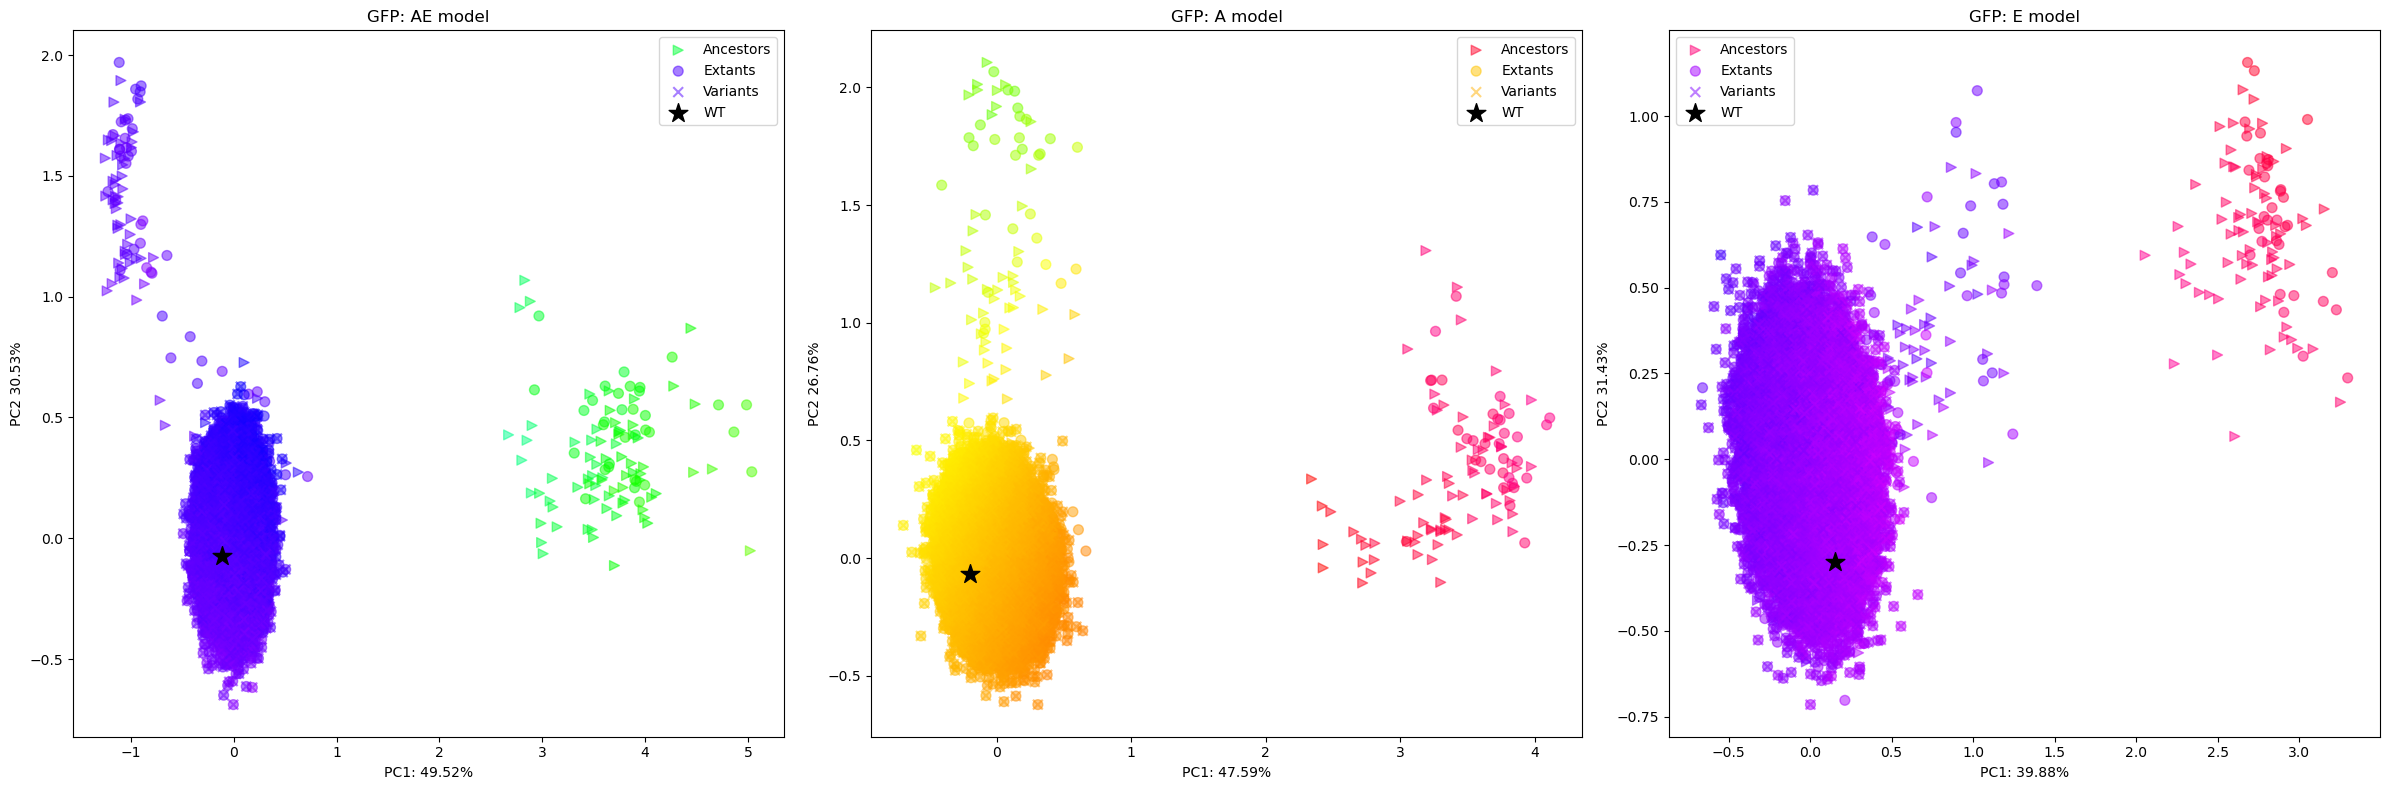

In [585]:
model_reps = [gfp_ae_latent, gfp_a_latent, gfp_e_latent]
labels = ["AE model", "A model", "E model"]

fig, axes = plt.subplots(1, 3, figsize=(24, 8), subplot_kw={'projection': '3d'})

for rep, label, ax in zip(model_reps, labels, axes):
    plot_latent_3D(rep, "GFP_AEQVI/1-238", label, ax, "GFP", rgb=True)

  
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

for rep, label, ax in zip(model_reps, labels, axes):
    plot_latent_2D(rep, "GFP_AEQVI/1-238", label, ax, "GFP", rgb=True)

plt.tight_layout()
plt.show()



# GB1

In [605]:
path = "/Users/sebs_mac/uni_OneDrive/honours/data/gb1/alns/"
gb1_ae = pd.read_pickle(path + "gb1_ancestors_extants_no_dupes.pkl")

variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/SPG1_STRSG_Wu_2016.csv")
variants.drop(columns=["DMS_score", "DMS_score_bin"], inplace=True)
variants.rename(columns={"mutant": "id", "mutated_sequence": "sequence"}, inplace=True)

all_gb1s = pd.concat([gb1_ae, variants], ignore_index=True)

one_hot = all_gb1s["sequence"].apply(st.seq_to_one_hot)
all_gb1s["encoding"] = one_hot

gb1_ae_dataset = MSA_Dataset(all_gb1s["encoding"], pd.Series(np.arange(len(one_hot))), all_gb1s["id"])
gb1_ae_loader = torch.utils.data.DataLoader(
    gb1_ae_dataset, batch_size=1, shuffle=False
)


seq_len = gb1_ae_dataset[0][0].shape[0]
input_dims = seq_len * settings["AA_count"]

device = torch.device("mps")
model = SeqVAE(
    dim_latent_vars=settings["latent_dims"],
    dim_msa_vars=input_dims,
    num_hidden_units=settings["hidden_dims"],
    settings=settings,
    num_aa_type=settings["AA_count"],
)

### GB1-AE model 

In [606]:
model = model.to(device)

model.load_state_dict(torch.load("/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/gb1_standard/gb1_ae/gb1_ae_r1/gb1_ae_r1_model_state.pt",
                                  map_location=device))

gb1_ae_latent = get_mean_z(model, gb1_ae_loader, device, 10)
gb1_ae_latent.head()

id                                    z
0  N0_gb1_tree_1   [1.264954, -1.2148551, -1.2515177]
1  N1_gb1_tree_1  [1.2629069, -1.2148434, -1.2461262]
2  N3_gb1_tree_1  [1.2939405, -1.2277093, -1.2478626]
3  N6_gb1_tree_1  [1.2474121, -1.1894442, -1.2422252]
4  N7_gb1_tree_1  [1.2977753, -1.2345766, -1.2606915]

In [607]:
model.load_state_dict(torch.load("/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/gb1_standard/gb1_a/gb1_a_r2/gb1_a_r2_model_state.pt",
                                  map_location=device))

gb1_a_latent = get_mean_z(model, gb1_ae_loader, device, 10)
gb1_a_latent.head()

id                                    z
0  N0_gb1_tree_1   [1.0043375, 0.04598433, 0.5177016]
1  N1_gb1_tree_1   [1.0130008, 0.04367737, 0.5186766]
2  N3_gb1_tree_1   [1.0313399, 0.04257999, 0.5192544]
3  N6_gb1_tree_1  [1.0117369, 0.04135188, 0.51346797]
4  N7_gb1_tree_1  [1.0243307, 0.038147163, 0.5396959]

In [608]:
model.load_state_dict(torch.load("/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/gb1_standard/gb1_e/gb1_e_r2/gb1_e_r2_model_state.pt",
                                  map_location=device))

gb1_e_latent = get_mean_z(model, gb1_ae_loader, device, 10)
gb1_e_latent.head()

id                                        z
0  N0_gb1_tree_1  [-0.022971801, -4.5720325, -0.96289253]
1  N1_gb1_tree_1    [-0.031134889, -4.543302, -0.9386162]
2  N3_gb1_tree_1    [-0.05476846, -4.4381866, -0.9404602]
3  N6_gb1_tree_1    [-0.06439778, -4.476783, -0.93814963]
4  N7_gb1_tree_1    [-0.050573774, -4.366651, -0.9262215]

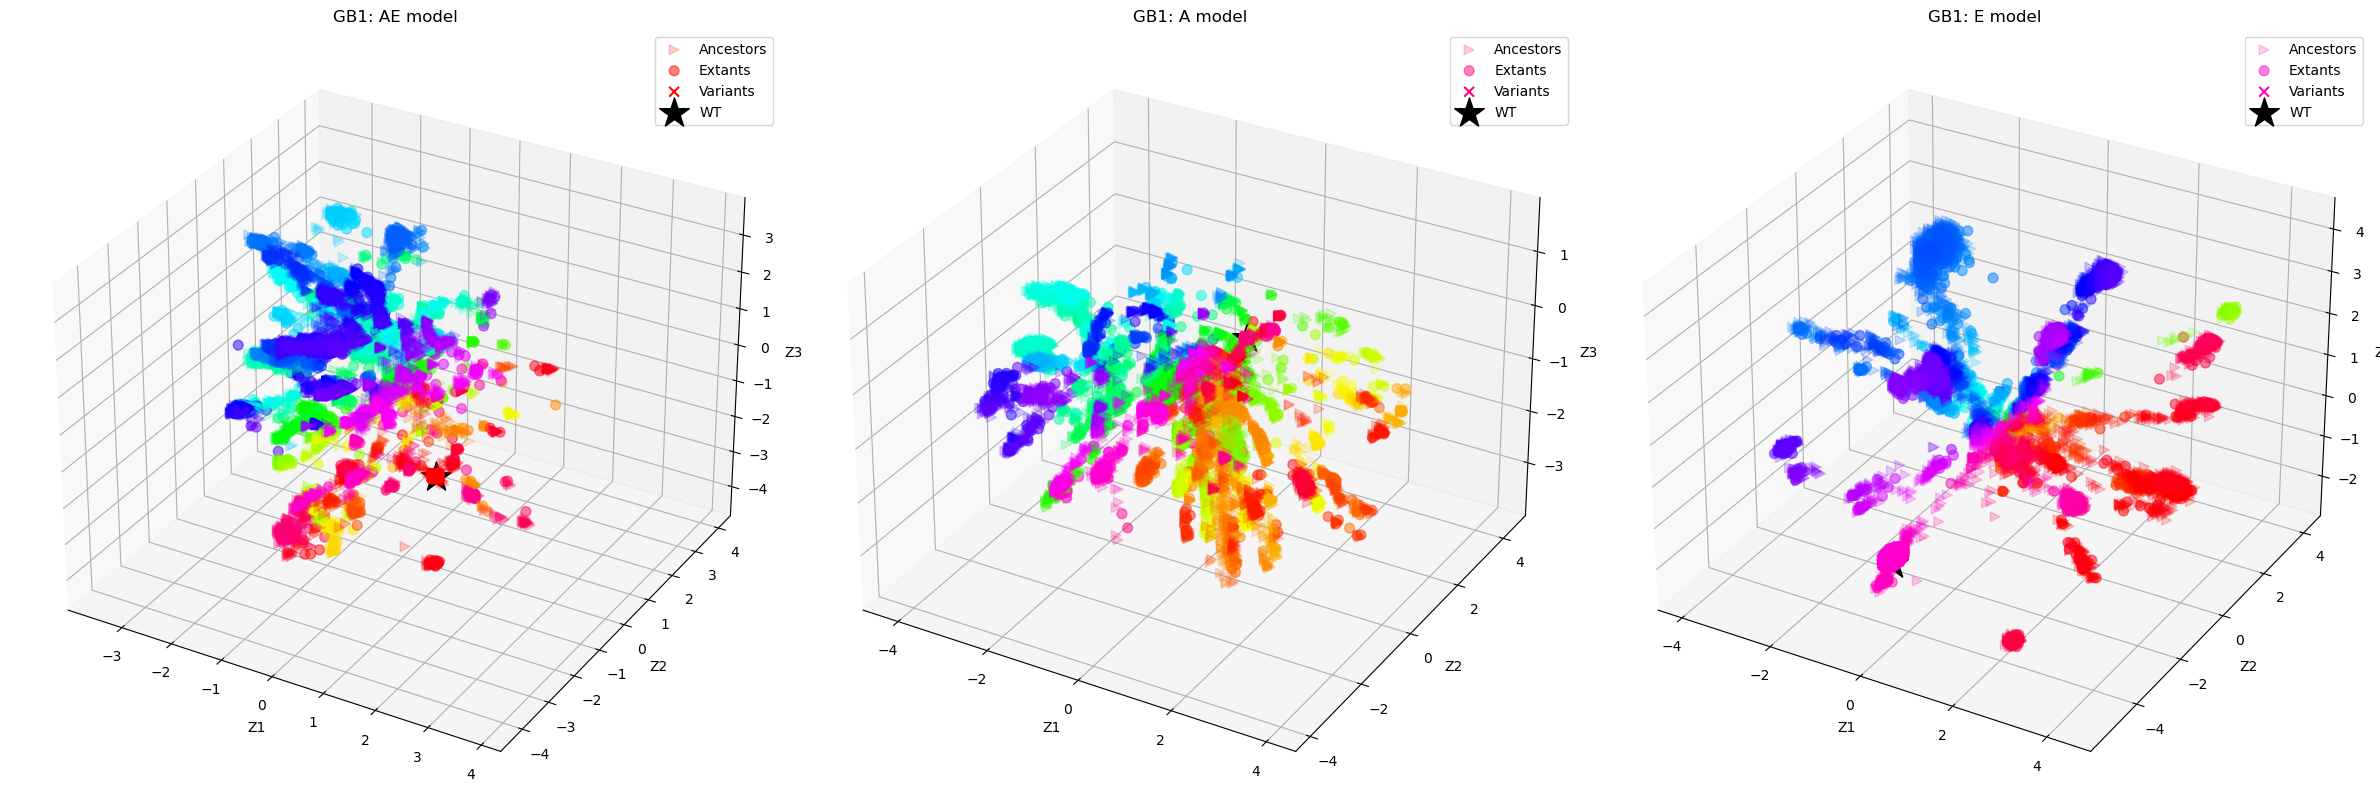

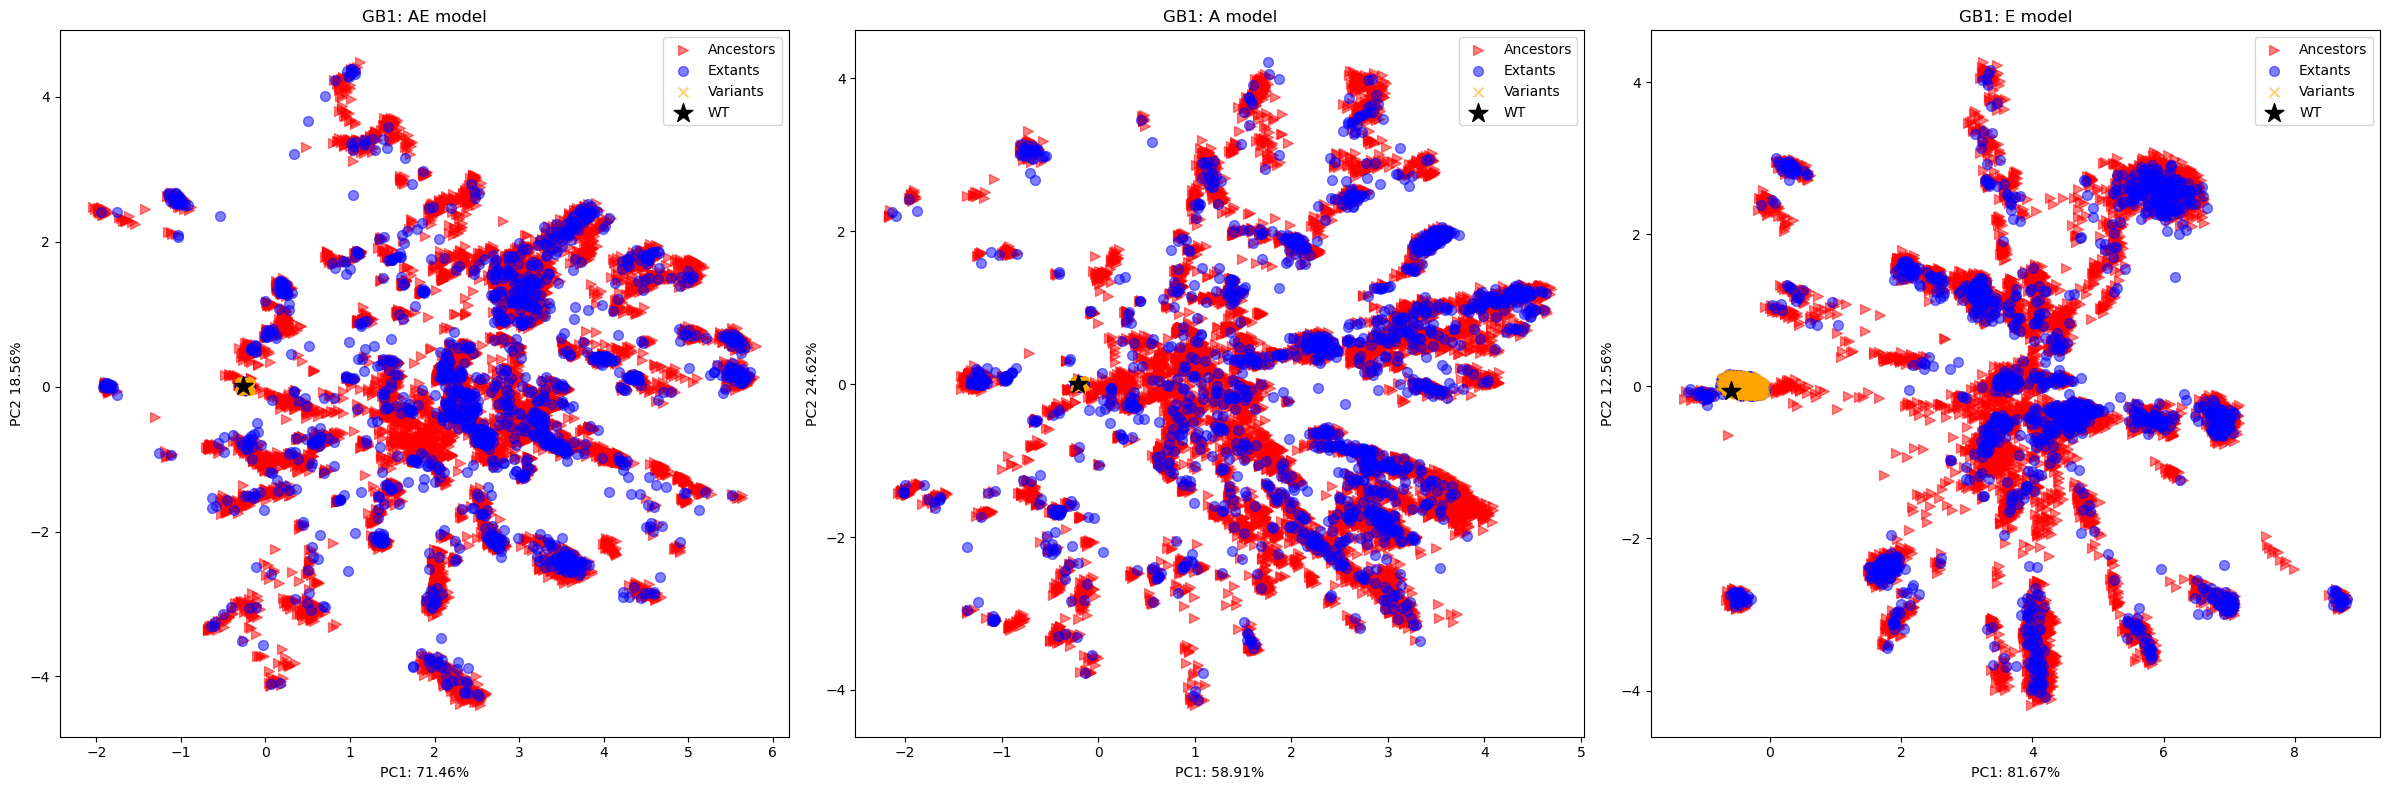

In [612]:


model_reps = [gb1_ae_latent, gb1_a_latent, gb1_e_latent]
labels = ["AE model", "A model", "E model"]

fig, axes = plt.subplots(1, 3, figsize=(24, 8), subplot_kw={'projection': '3d'})

for rep, label, ax in zip(model_reps, labels, axes):
    plot_latent_3D(rep, "SPG1_STRSG/1-448", label, ax, "GB1", rgb=True)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

for rep, label, ax in zip(model_reps, labels, axes):
    plot_latent_2D(rep, "SPG1_STRSG/1-448", label, ax, "GB1", rgb=False)

plt.tight_layout()
plt.show()

# A4

In [466]:
path = "/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns/"
a4_ae = pd.read_pickle(path + "a4_ancestors_extants_no_dupes.pkl")

variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/A4_HUMAN_Seuma_2022.csv")
variants.drop(columns=["DMS_score", "DMS_score_bin"], inplace=True)
variants.rename(columns={"mutant": "id", "mutated_sequence": "sequence"}, inplace=True)

all_a4s = pd.concat([a4_ae, variants], ignore_index=True)
all_a4s


id  \
0                        N0_a4_tree_0   
1                        N1_a4_tree_0   
2                        N4_a4_tree_0   
3                        N8_a4_tree_0   
4                        N9_a4_tree_0   
...                               ...   
32120  UniRef100_UPI001F4FC2D8/43-698   
32121  UniRef100_UPI00214EB55D/43-700   
32122   UniRef100_UPI0018E23C0C/9-590   
32123   UniRef100_UPI0014030BD3/7-634   
32124     UniRef100_A0A4C1VH27/19-582   

                                                sequence  
0      ----------------------------------------------...  
1      ----LALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...  
2      ----LALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...  
3      ----LALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...  
4      ----LALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...  
...                                                  ...  
32120  ----------------------------------------------...  
32121  ----------------------------------------------...  
32122  ----------------------------------------------...  
32123  -------WMRLLAVAMAVVVVMAAPPPSSAHPQVAMFCGKLNMHLD...  
32124  ----------------------------------------------...  

[32125 rows x 2 columns]

In [482]:
one_hot = all_a4s["sequence"].apply(st.seq_to_one_hot)
all_a4s["encoding"] = one_hot

a4_ae_dataset = MSA_Dataset(all_a4s["encoding"], pd.Series(np.arange(len(one_hot))), all_a4s["id"])
a4_ae_loader = torch.utils.data.DataLoader(
    a4_ae_dataset, batch_size=1, shuffle=False
)

seq_len = a4_ae_dataset[0][0].shape[0]
input_dims = seq_len * settings["AA_count"]

device = torch.device("mps")
model = SeqVAE(
    dim_latent_vars=settings["latent_dims"],
    dim_msa_vars=input_dims,
    num_hidden_units=settings["hidden_dims"],
    settings=settings,
    num_aa_type=settings["AA_count"],
)

### A4-AE model 

In [483]:
model = model.to(device)

model.load_state_dict(torch.load("/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/a4_standard/a4_ae/a4_ae_r2/a4_ae_r2_model_state.pt",
                                  map_location=device))

a4_ae_latent = get_mean_z(model, a4_ae_loader, device, 10)
a4_ae_latent.head()

id                                     z
0  N0_a4_tree_0  [2.290617, -0.020340467, -1.0821265]
1  N1_a4_tree_0   [2.728876, -0.17993425, -1.8945961]
2  N4_a4_tree_0  [2.6543043, -0.20152941, -1.9687592]
3  N8_a4_tree_0  [2.6501853, -0.23390286, -1.8739766]
4  N9_a4_tree_0  [2.6519973, -0.23267846, -1.9052114]

In [484]:
model.load_state_dict(torch.load("/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/a4_standard/a4_a/a4_a_r9/a4_a_r9_model_state.pt",
                                  map_location=device))

a4_a_latent = get_mean_z(model, a4_ae_loader, device, 10)
a4_a_latent.head()

id                                     z
0  N0_a4_tree_0   [-0.6450412, -1.333639, 0.73027986]
1  N1_a4_tree_0  [-1.6369364, -0.45632052, 1.4112079]
2  N4_a4_tree_0   [-1.6416527, -0.4351654, 1.4002986]
3  N8_a4_tree_0   [-1.7238591, -0.5194954, 1.3746969]
4  N9_a4_tree_0    [-1.6656678, -0.4419748, 1.394079]

In [485]:
model.load_state_dict(torch.load("/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/a4_standard/a4_e/a4_e_r9/a4_e_r9_model_state.pt",
                                  map_location=device))

a4_e_latent = get_mean_z(model, a4_ae_loader, device, 10)
a4_e_latent.head()

id                                     z
0  N0_a4_tree_0    [1.0844382, -1.640088, -2.8631992]
1  N1_a4_tree_0   [0.2259634, -1.2571849, -1.7225205]
2  N4_a4_tree_0   [0.27359962, -1.295606, -1.6962166]
3  N8_a4_tree_0   [0.2688212, -1.2962373, -1.6329769]
4  N9_a4_tree_0  [0.30032378, -1.2124743, -1.6361178]

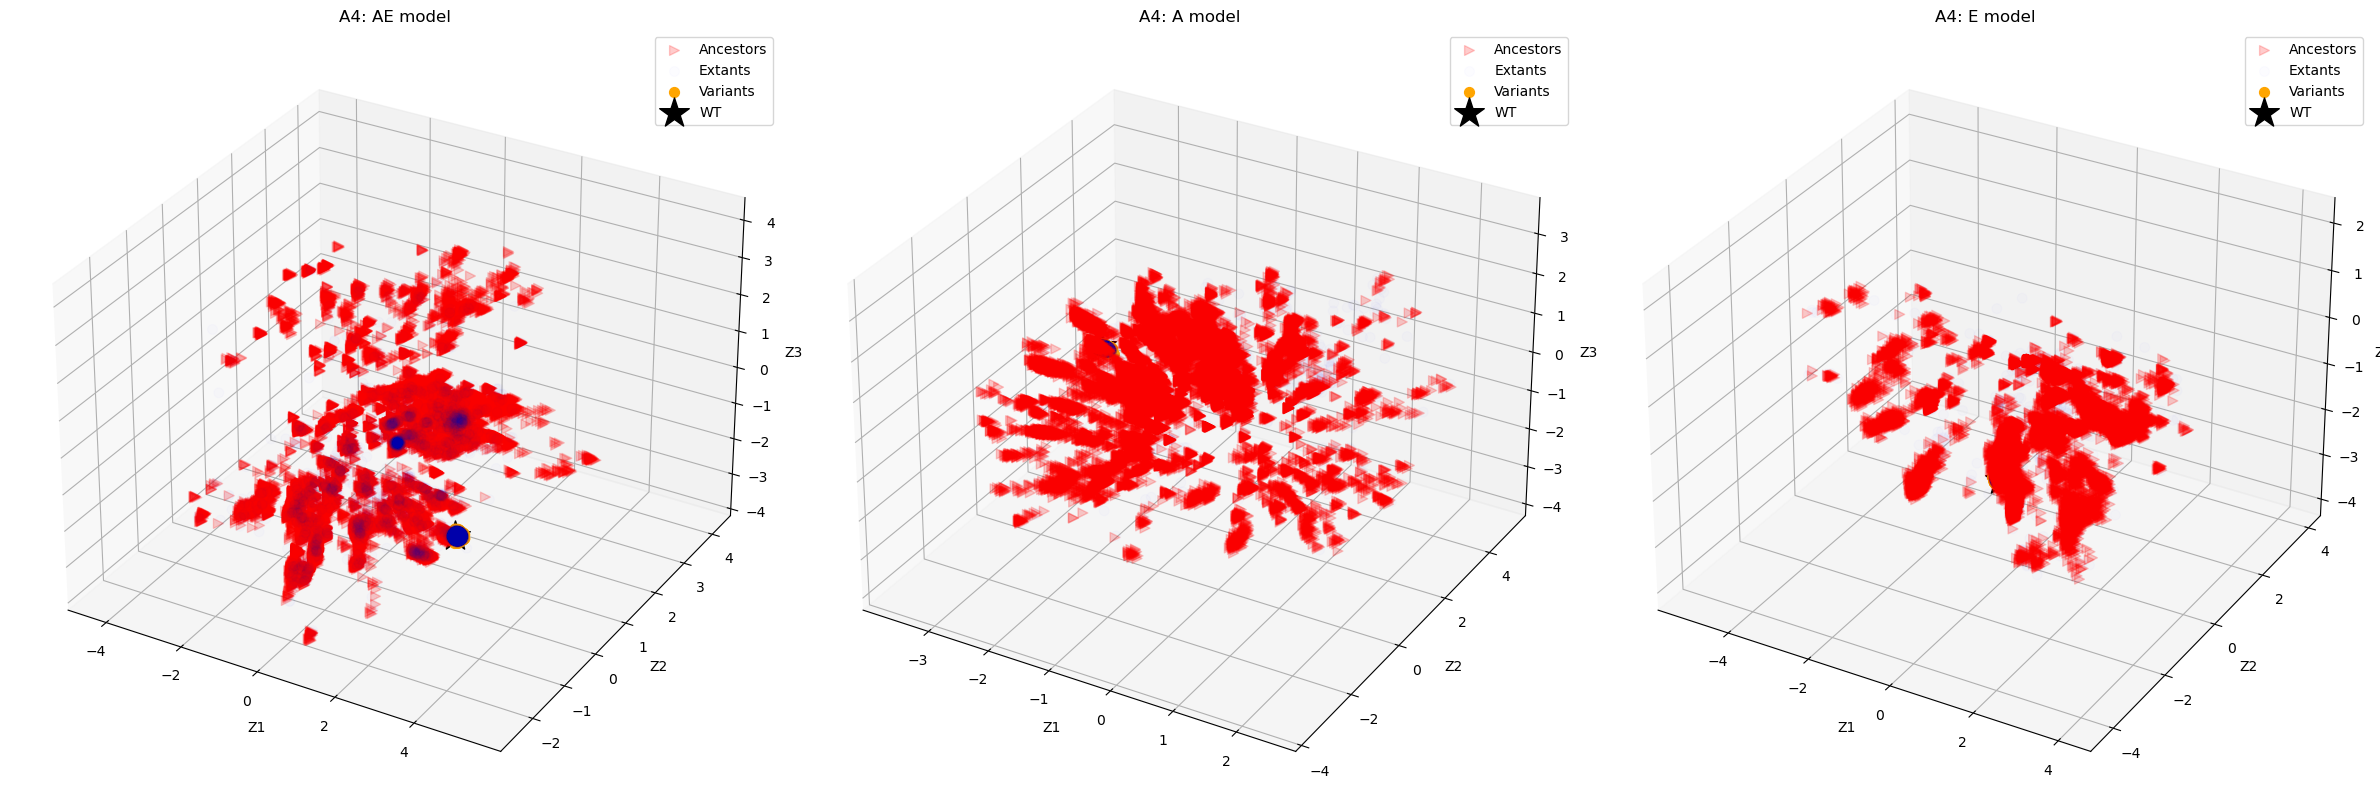

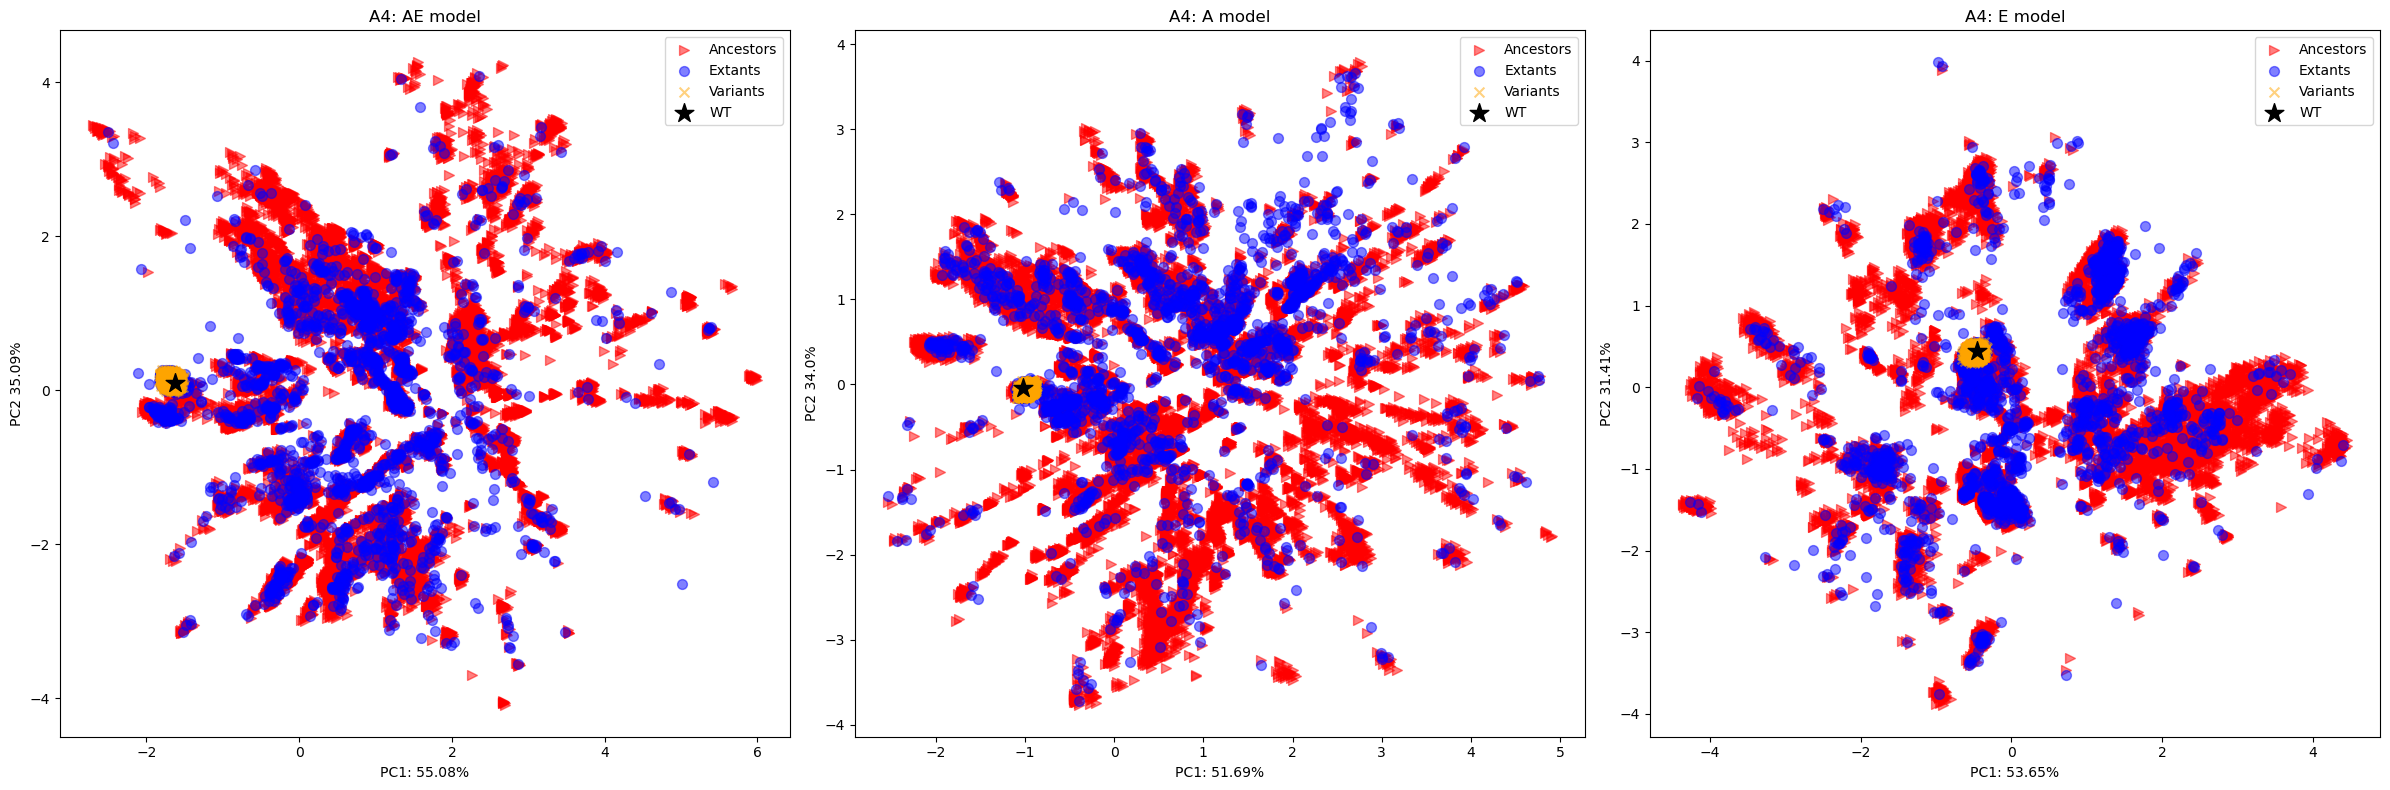

In [572]:
model_reps = [a4_ae_latent, a4_a_latent, a4_e_latent]
labels = ["AE model", "A model", "E model"]

fig, axes = plt.subplots(1, 3, figsize=(24, 8), subplot_kw={'projection': '3d'})

for rep, label, ax in zip(model_reps, labels, axes):
    plot_latent_3D(rep, "A4_HUMAN/1-770", label, ax, "A4", rgb=False)
   

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

for rep, label, ax in zip(model_reps, labels, axes):
    plot_latent_2D(rep, "A4_HUMAN/1-770", label, ax, "A4", rgb=False)

plt.tight_layout()
plt.show()

# GCN4

In [593]:
path = "/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/"
gcn4_ae = pd.read_pickle(path + "gcn4_ancestors_extants_no_dupes.pkl")

variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/GCN4_YEAST_Staller_2018.csv")
variants.drop(columns=["DMS_score", "DMS_score_bin"], inplace=True)
variants.rename(columns={"mutant": "id", "mutated_sequence": "sequence"}, inplace=True)

all_gcn4s = pd.concat([gcn4_ae, variants], ignore_index=True)

one_hot = all_gcn4s["sequence"].apply(st.seq_to_one_hot)
all_gcn4s["encoding"] = one_hot

gcn4_ae_dataset = MSA_Dataset(all_gcn4s["encoding"], pd.Series(np.arange(len(one_hot))), all_gcn4s["id"])
gcn4_ae_loader = torch.utils.data.DataLoader(
    gcn4_ae_dataset, batch_size=1, shuffle=False
)

seq_len = gcn4_ae_dataset[0][0].shape[0]
input_dims = seq_len * settings["AA_count"]

device = torch.device("mps")
model = SeqVAE(
    dim_latent_vars=settings["latent_dims"],
    dim_msa_vars=input_dims,
    num_hidden_units=settings["hidden_dims"],
    settings=settings,
    num_aa_type=settings["AA_count"],
)

### GCN4-AE model 

In [594]:
model = model.to(device)

model.load_state_dict(torch.load("/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/gcn4_standard/gcn4_ae/gcn4_ae_r8/gcn4_ae_r8_model_state.pt",
                                  map_location=device))

gcn4_ae_latent = get_mean_z(model, gcn4_ae_loader, device, 10)
gcn4_ae_latent.head()

id                                      z
0            GCN4_YEAST/1-281   [-1.6769888, -0.6782554, -3.9098632]
1  UniRef100_A0A6V8SDC1/2-278   [-1.5332569, -0.5730814, -3.7692704]
2      UniRef100_P03069/2-278  [-1.6052397, -0.65244454, -3.7362688]
3  UniRef100_A0A6V8RYM2/2-278   [-1.6234444, -0.5070008, -3.8385034]
4  UniRef100_A0A7I9BU78/2-278   [-1.5597581, -0.4915288, -3.5663106]

In [595]:
model.load_state_dict(torch.load("/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/gcn4_standard/gcn4_a/gcn4_a_r6/gcn4_a_r6_model_state.pt",
                                  map_location=device))

gcn4_a_latent = get_mean_z(model, gcn4_ae_loader, device, 10)
gcn4_a_latent.head()

id                                     z
0            GCN4_YEAST/1-281    [0.20298217, 3.334554, -0.9111538]
1  UniRef100_A0A6V8SDC1/2-278   [0.2651527, 3.2906003, -0.90068513]
2      UniRef100_P03069/2-278    [0.33489156, 3.415723, -1.0318266]
3  UniRef100_A0A6V8RYM2/2-278  [0.33153468, 3.3182442, -0.89142877]
4  UniRef100_A0A7I9BU78/2-278   [0.34584293, 3.2016892, -0.8209562]

In [596]:
model.load_state_dict(torch.load("/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/gcn4_standard/gcn4_e/gcn4_e_r1/gcn4_e_r1_model_state.pt",
                                  map_location=device))

gcn4_e_latent = get_mean_z(model, gcn4_ae_loader, device, 10)
gcn4_e_latent.head()

id                                     z
0            GCN4_YEAST/1-281  [-1.6315832, 0.105465196, 1.1613547]
1  UniRef100_A0A6V8SDC1/2-278   [-1.6817265, 0.102613226, 1.144194]
2      UniRef100_P03069/2-278   [-1.7013664, 0.15206473, 1.2855494]
3  UniRef100_A0A6V8RYM2/2-278     [-1.602713, 0.1280923, 1.3231739]
4  UniRef100_A0A7I9BU78/2-278    [-1.5301968, 0.2188993, 1.4071842]

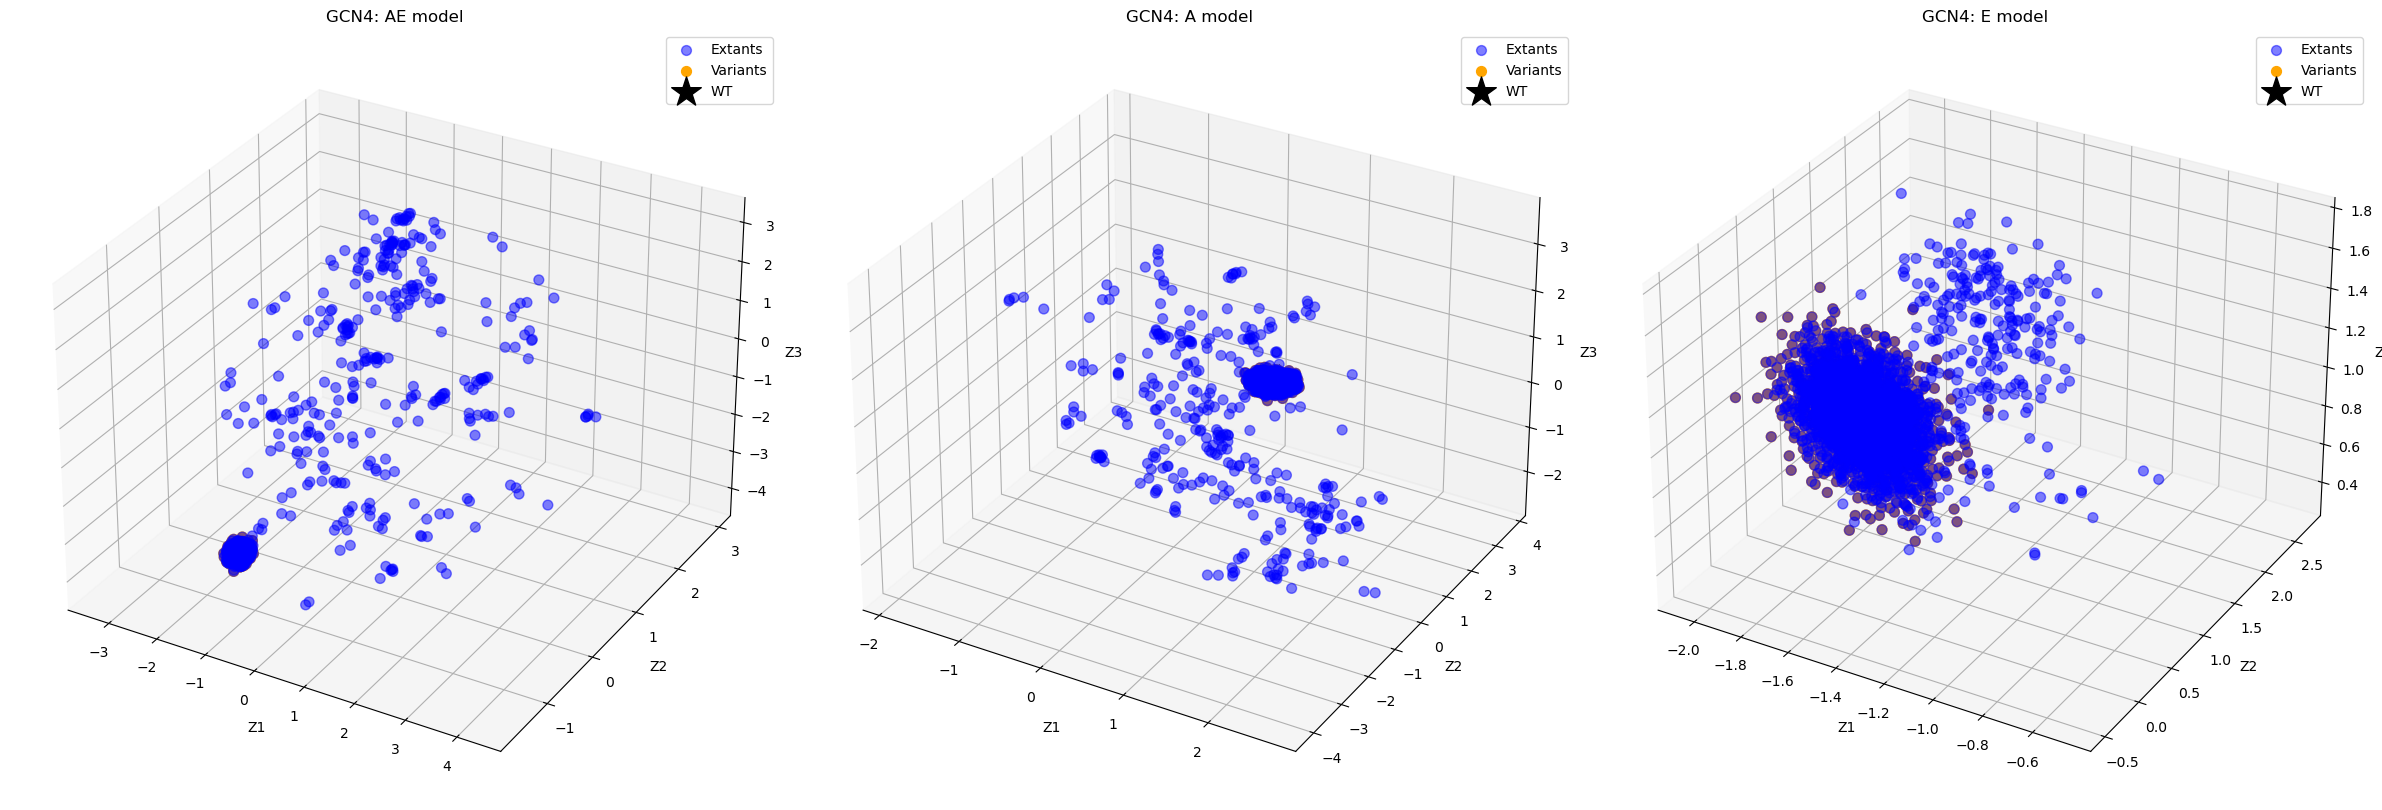

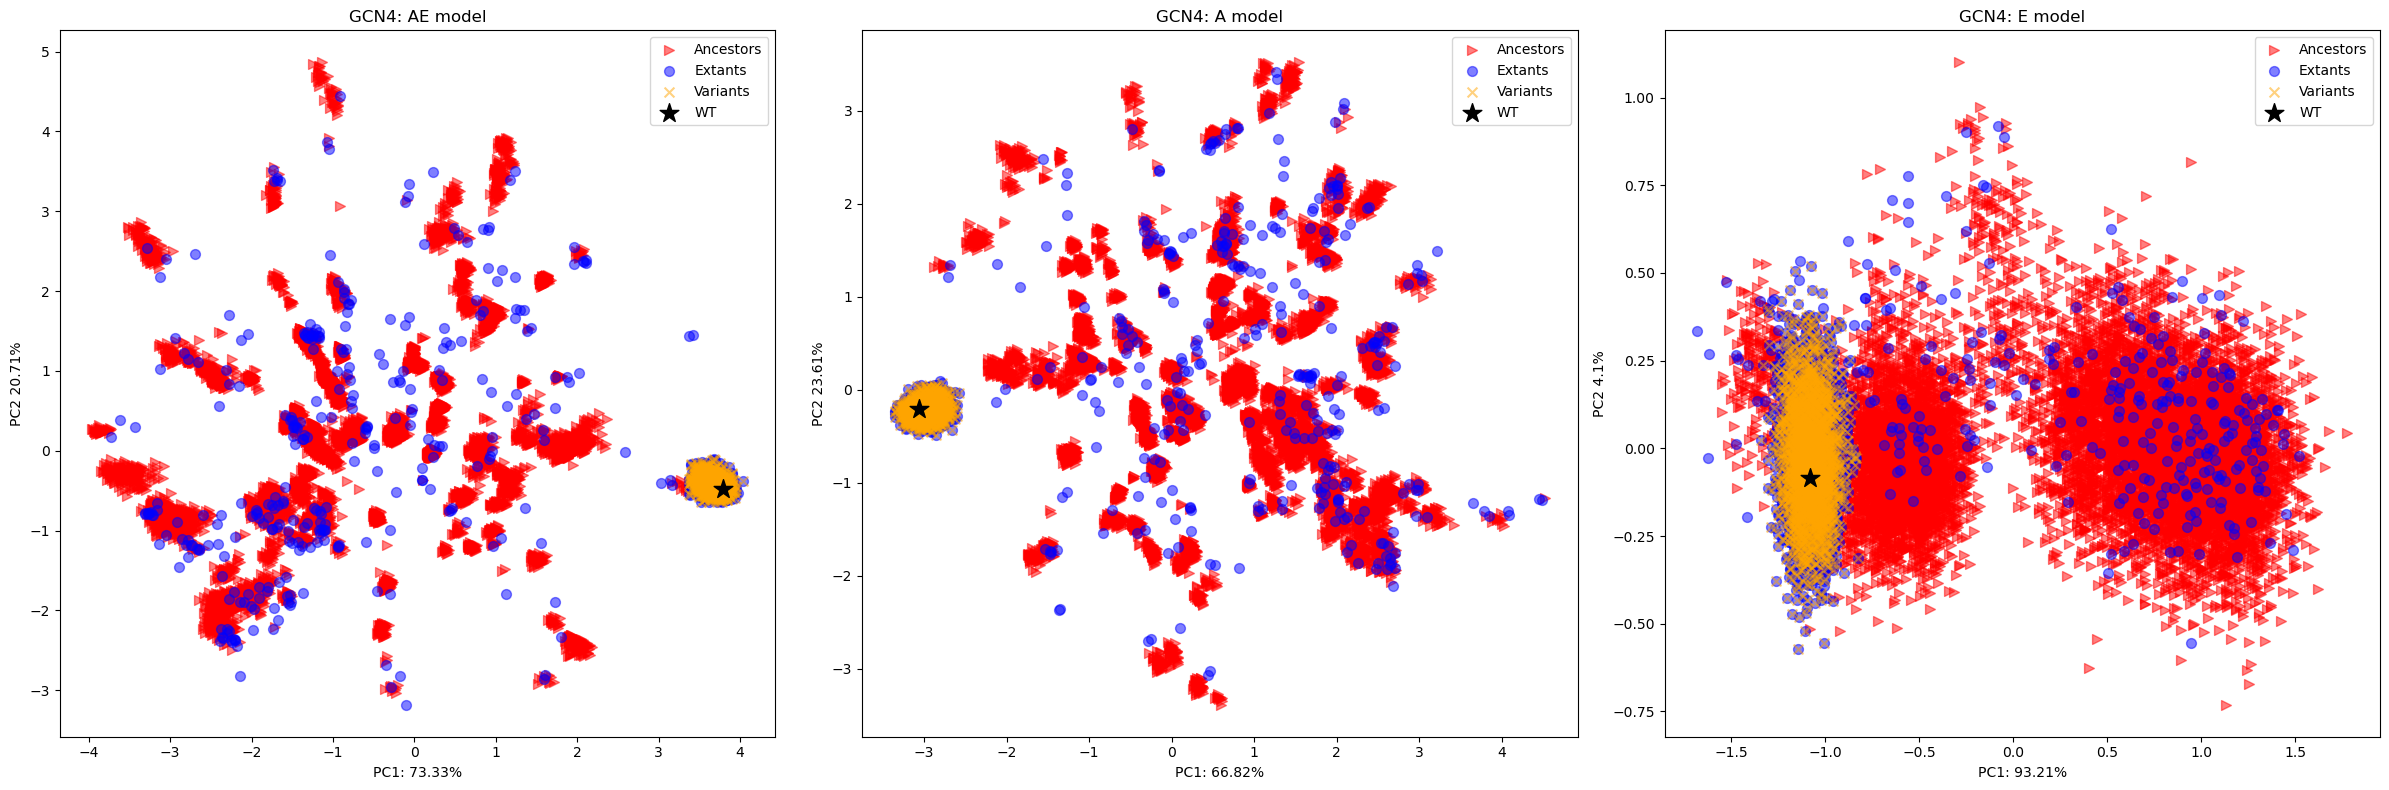

In [604]:
model_reps = [gcn4_ae_latent, gcn4_a_latent, gcn4_e_latent]
labels = ["AE model", "A model", "E model"]

fig, axes = plt.subplots(1, 3, figsize=(24, 8), subplot_kw={'projection': '3d'})

for rep, label, ax in zip(model_reps, labels, axes):
    plot_latent_3D(rep, "GCN4_YEAST/1-281", label, ax, "GCN4", rgb=False)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

for rep, label, ax in zip(model_reps, labels, axes):
    plot_latent_2D(rep, "GCN4_YEAST/1-281", label, ax, "GCN4", rgb=False)

plt.tight_layout()
plt.show()

### Tree example 

In [355]:
gcn4_tree_0 = st.read_aln_file("tree_0_ancestors.fa")
gcn4_tree_0

Reading the alignment: tree_0_ancestors.fa
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 694


id  \
0                  N0_gcn4_tree_0   
1                  N1_gcn4_tree_0   
2                  N2_gcn4_tree_0   
3                  N3_gcn4_tree_0   
4                  N4_gcn4_tree_0   
..                            ...   
689  UniRef100_A0A2H3I9P9/247-531   
690  UniRef100_A0A0D2JFS6/140-356   
691       UniRef100_W9XLE4/26-239   
692   UniRef100_A0A0D2EC58/22-237   
693   UniRef100_A0A0D2DMH2/22-236   

                                              sequence  
0    -SEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...  
1    -SEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...  
2    -SEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...  
3    -SEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...  
4    -SEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...  
..                                                 ...  
689  ----------------------TPNYQKNQHKQHQTHPQQHRRVMS...  
690  ---------------------------------------SHDDFMD...  
691  ----------------------------------------------...  
692  -------------------------------------------FFN...  
693  -------------------------------------------FFN...  

[694 rows x 2 columns]

In [356]:
one_hot = gcn4_tree_0["sequence"].apply(st.seq_to_one_hot)
gcn4_tree_0["encoding"] = one_hot

gcn4_tree_0

id  \
0                  N0_gcn4_tree_0   
1                  N1_gcn4_tree_0   
2                  N2_gcn4_tree_0   
3                  N3_gcn4_tree_0   
4                  N4_gcn4_tree_0   
..                            ...   
689  UniRef100_A0A2H3I9P9/247-531   
690  UniRef100_A0A0D2JFS6/140-356   
691       UniRef100_W9XLE4/26-239   
692   UniRef100_A0A0D2EC58/22-237   
693   UniRef100_A0A0D2DMH2/22-236   

                                              sequence  \
0    -SEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...   
1    -SEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...   
2    -SEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...   
3    -SEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...   
4    -SEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...   
..                                                 ...   
689  ----------------------TPNYQKNQHKQHQTHPQQHRRVMS...   
690  ---------------------------------------SHDDFMD...   
691  ----------------------------------------------...   
692  -------------------------------------------FFN...   
693  -------------------------------------------FFN...   

                                              encoding  
0    [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1    [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2    [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
3    [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
4    [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
..                                                 ...  
689  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
690  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
691  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
692  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
693  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  

[694 rows x 3 columns]

In [357]:
gcn4_tree_0_dataset = MSA_Dataset(gcn4_tree_0["encoding"], pd.Series(np.arange(len(one_hot))), gcn4_tree_0["id"])
gcn4_tree_0_loader = torch.utils.data.DataLoader(
   gcn4_tree_0_dataset, batch_size=1, shuffle=False
)

In [358]:
seq_len = gcn4_tree_0_dataset[0][0].shape[0]
input_dims = seq_len * settings["AA_count"]

device = torch.device("mps")
model = SeqVAE(
    dim_latent_vars=settings["latent_dims"],
    dim_msa_vars=input_dims,
    num_hidden_units=settings["hidden_dims"],
    settings=settings,
    num_aa_type=settings["AA_count"],
)

In [361]:
model = model.to(device)

model.load_state_dict(torch.load("/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/gcn4_standard/gcn4_ae/gcn4_ae_r8/gcn4_ae_r8_model_state.pt",
                                  map_location=device))

<All keys matched successfully>

In [443]:
gcn4_tree_0_latent = get_mean_z(model, gcn4_tree_0_loader, device)

In [444]:
gcn4_tree_0_latent

id                                      z
0                  N0_gcn4_tree_0   [-1.6007929, -0.51707137, -4.071351]
1                  N1_gcn4_tree_0  [-1.5412515, -0.58508533, -3.8046014]
2                  N2_gcn4_tree_0   [-1.5667948, -0.5059692, -3.7506006]
3                  N3_gcn4_tree_0  [-1.5121874, -0.63431025, -3.7726243]
4                  N4_gcn4_tree_0  [-1.6633615, -0.52366364, -3.6864471]
..                            ...                                    ...
689  UniRef100_A0A2H3I9P9/247-531    [0.36779356, -1.0742881, 0.9851023]
690  UniRef100_A0A0D2JFS6/140-356     [2.7820516, 0.79392344, 2.1174734]
691       UniRef100_W9XLE4/26-239     [2.8474126, 0.64529616, 1.5295937]
692   UniRef100_A0A0D2EC58/22-237     [3.1631072, 0.55636173, 2.3309898]
693   UniRef100_A0A0D2DMH2/22-236     [2.7418098, 0.44186145, 2.0770912]

[694 rows x 2 columns]

In [445]:
rgb = [rgb_to_hex_normalized(*((z - np.min(z)) / (np.max(z) - np.min(z)))) for z in gcn4_tree_0_latent["z"]]

In [446]:
gcn4_tree_0_latent["COLOR"] = rgb
gcn4_tree_0_latent.drop(columns=["z"], inplace=True)
gcn4_tree_0_latent

id    COLOR
0                  N0_gcn4_tree_0  #B1FF00
1                  N1_gcn4_tree_0  #B3FF00
2                  N2_gcn4_tree_0  #ABFF00
3                  N3_gcn4_tree_0  #B7FF00
4                  N4_gcn4_tree_0  #A3FF00
..                            ...      ...
689  UniRef100_A0A2H3I9P9/247-531  #B200FF
690  UniRef100_A0A0D2JFS6/140-356  #FF00A9
691       UniRef100_W9XLE4/26-239  #FF0066
692   UniRef100_A0A0D2EC58/22-237  #FF00AD
693   UniRef100_A0A0D2DMH2/22-236  #FF00B5

[694 rows x 2 columns]

In [451]:
def write_itol_dataset_symbol(filename: str, data: pd.DataFrame, symbol: int = 2, size: int = 2, fill: float = 1.0, position: float = 1.0, label: float=0.5):

    ids = [x.split("_")[0] if "tree" in x else x for x in data["id"]] 
    data["NODE_ID"] = ids

    nodes = [symbol] * len(data)
    data["SYMBOL"] = nodes

    nodes = [size] * len(data)
    data["SIZE"] = nodes

    nodes = [fill] * len(data)
    data["FILL"] = nodes

    nodes = [position] * len(data)
    data["POSITION"] = nodes

    with open(filename, "w") as file:

        print("DATASET_SYMBOL", file=file)
        print("SEPARATOR COMMA", file=file)
        print("DATASET_LABEL,example symbols", file=file)
        print("COLOR,#ffff00", file=file)
        print("DATA", file=file)
        print("#NODE_ID, SYMBOL, SIZE, COLOR, FILL, POSITION", file=file)

        for _, row in data.iterrows():
                    file.write(f"{row['NODE_ID']},{row['SYMBOL']},{row['SIZE']},{row['COLOR']},{row['FILL']},{row['POSITION']}\n")



In [452]:
write_itol_dataset_symbol("annotations.txt", gcn4_tree_0_latent)